In [162]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from collections import defaultdict

from wordcloud import WordCloud

import sys

import os

In [163]:
# Installing dependencies: 
#!{sys.executable} -m pip install wordcloud

### **Reading Animelist.csv**

In [164]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [165]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])

In [166]:
display(rating_df.head())

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [167]:
len(rating_df)

5000000

### **Data Processing**

In [168]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >=400 ].index)].copy()

In [169]:
print(len(rating_df))

3246641


In [170]:
min_rating = min(rating_df["rating"])
min_rating

0

In [171]:
max_rating = max(rating_df["rating"])
max_rating

10

In [172]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.122732695114736)

In [173]:
rating_df["rating"] = rating_df['rating'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [174]:
rating_df.duplicated().sum()

np.int64(0)

In [175]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [ ]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x : i for i, x in enumerate(user_ids)}
user2user_decoded = {i : x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [177]:
n_users = len(user2user_encoded)
n_users

4203

In [178]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)


In [179]:
n_animes = len(anime2anime_encoded)
n_animes

17149

In [180]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [181]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [182]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [183]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [184]:
X_train, X_test, y_train, y_test = (X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:])

In [185]:
len(X_train)

3245641

In [186]:
len(X_test)

1000

In [187]:
type(X_train)

numpy.ndarray

In [188]:
X_train_array = [X_train[: , 0], X_train[:, 1]]

X_test_array = [X_test[: , 0], X_test[:, 1]]

In [189]:
type(X_train_array[0])

numpy.ndarray

### **Model Architecture**

In [190]:
def RecommenderNET():
    embedding_size = 128

    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])

    anime_embedding = Embedding(name = "anime_embedding", input_dim=n_animes, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize = True, axes = 2)([user_embedding, anime_embedding]) 

    x = Flatten()(x)

    x = Dense(1, kernel_initializer = "he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs = [user, anime], outputs = x)
    model.compile(loss = "binary_crossentropy", metrics = ["mae", "mse"], optimizer = "Adam")

    return model

In [191]:
model = RecommenderNET()

In [192]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [193]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8 


def lrfn(epoch):
    if epoch<ramup_epochs:
        return(max_lr-start_lr)/ramup_epochs*epoch + start_lr
    
    elif epoch<ramup_epochs + sustain_epochs:
        return max_lr
    
    else:
        return(max_lr-min_lr)*exp_decay **(epoch-ramup_epochs-sustain_epochs)+min_lr


In [194]:
lr_callback = LearningRateScheduler(lambda epoch : lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [195]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [196]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs = 20,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7974 - mae: 0.3816 - mse: 0.1963 - val_loss: 0.7203 - val_mae: 0.3656 - val_mse: 0.1683 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.7935 - mae: 0.3801 - mse: 0.1948 - val_loss: 0.7861 - val_mae: 0.3778 - val_mse: 0.1926 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.7879 - mae: 0.3780 - mse: 0.1926 - val_loss: 0.7929 - val_mae: 0.3787 - val_mse: 0.1946 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.7794 - mae: 0.3746 - mse: 0.1891 - val_loss: 0.7886 - val_mae: 0.3775 - val_mse: 0.1930 - learning_rate: 3.4000e-05


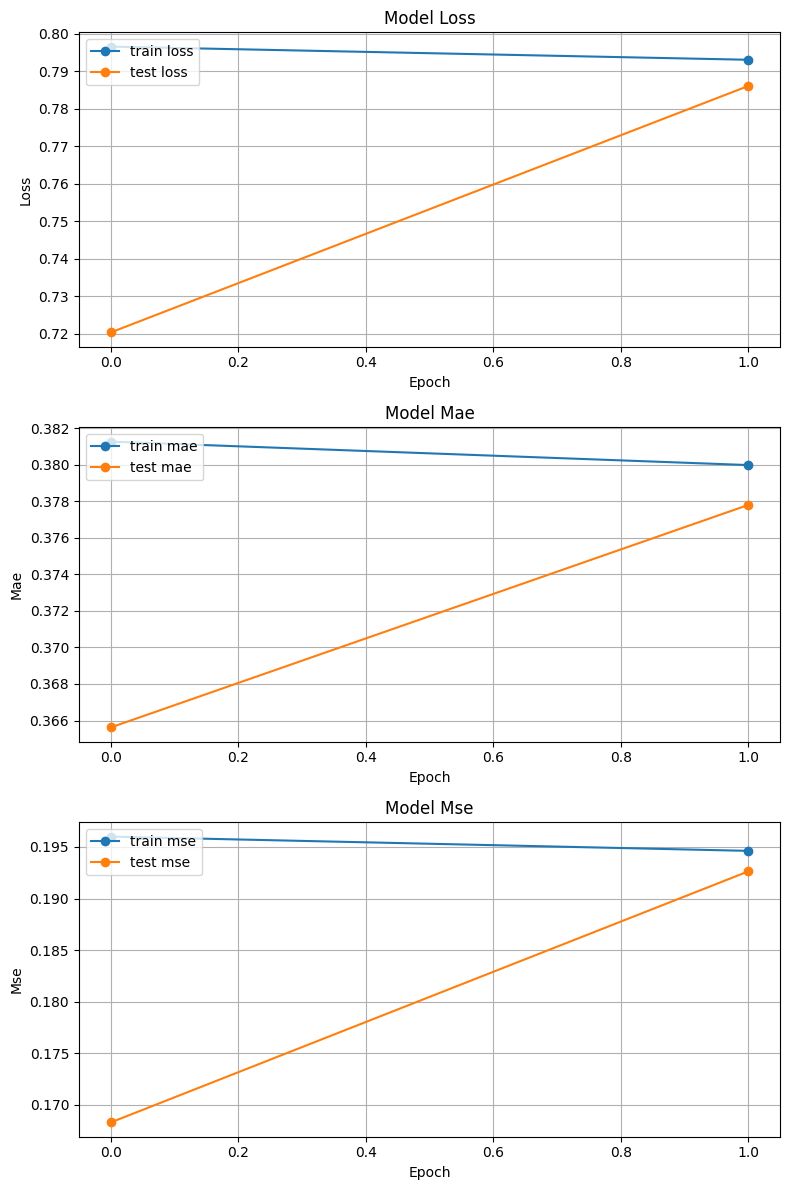

In [197]:
metrics = ["loss", "mae", "mse"]

#Create subplots

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True) 

plt.tight_layout()
plt.show()    

In [198]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [199]:
anime_weights = extract_weights("anime_embedding", model)

In [200]:
user_weights = extract_weights("user_embedding", model)

### **Reading Anime.CSV**

In [201]:
df = pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)

df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [202]:
df = df.replace("Unknown", np.nan)

In [203]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name    


In [204]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))


In [205]:
getAnimeName(6702)

'Fairy Tail'

In [206]:
df.sort_values(by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last")

In [207]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [208]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [209]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [210]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [211]:
getAnimeFrame(anime="Steins;Gate", df=df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### **Anime_With_Synopsi.CSV**

In [212]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [213]:
synopsis_df = pd.read_csv(INPUT_DIR+ "/anime_with_synopsis.csv", usecols=cols)

In [214]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [215]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [216]:
getSynopsis(anime=40028, df=df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [217]:
getSynopsis(anime="Steins;Gate", df=df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### **Content/Item Based Recommendation**

In [218]:
pd.set_option("max_colwidth", None)

In [219]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]

        print(f"Anime closest to {name}")     

        if return_dist:
            return dists, closest

        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print(f"Error occurred: {e}")


In [220]:
find_similar_animes(
    name = "Steins;Gate",
    anime_weights= anime_weights,
    anime2anime_encoded=anime2anime_encoded,
    anime2anime_decoded=anime2anime_decoded,
    df=df,
    synopsis_df=synopsis_df
)

Anime closest to Steins;Gate


,name,similarity,genre
1,The Pet Girl of Sakurasou,0.314021,"Slice of Life, Comedy, Drama, Romance, School"
2,Major S1,0.310597,"Comedy, Sports, Drama, Shounen"
3,Black Cat Detective,0.301893,"Action, Adventure, Cars, Comedy, Kids, Police"
4,Pussycat,0.298331,"Fantasy, Horror"
5,the FLY BanD!,0.294493,Music
6,KenIchi:The Mightiest Disciple OVA,0.288038,"Action, Martial Arts, Comedy, School, Shounen"
7,Toushindai My Lover: Minami tai Mecha-Minami,0.281993,Hentai
8,Hipira-kun Special,0.276886,"Comedy, Fantasy, Kids, Supernatural, Vampire"
9,Zero Duel Masters,0.275814,"Adventure, Comedy, Game, Sports"
10,Parasol Life,0.275232,Music


### **User Based Recommendation**

In [221]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n = 10, return_dist = False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])

        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users": decoded_id,  # Corrigido para "similar_users"
                    "similarity": similarity
                })

        # Aqui a coluna 'similar_users' será criada corretamente
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

        # Agora, garantimos que a coluna 'similar_users' existe antes de filtrar
        if "similar_users" in similar_users.columns:
            similar_users = similar_users[similar_users.similar_users != item_input]

        return similar_users

    except Exception as e:
        print("Error Occured", e)


In [222]:
find_similar_users(int(11558), user_weights= user_weights, user2user_encoded=user2user_encoded, user2user_decoded=user2user_decoded)

,similar_users,similarity
9,3508,0.302410
8,8595,0.297950
7,14908,0.270878
6,994,0.255767
5,2224,0.253764
4,7846,0.252938
3,16286,0.252385
2,14186,0.252219
1,4144,0.248111
0,4433,0.246615


In [223]:
def showWordCloud(all_genres):
    
    genres_cloud = WordCloud(width=700,height=400, background_color="white", colormap="gnuplot").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [224]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)

    return genres_list            


In [225]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    if animes_watched_by_user.empty:
        print(f"Nenhum rating encontrado para o usuário {user_id}.")
        return pd.DataFrame()  # ou pode retornar None ou uma string

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]

    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows


In [226]:
print(rating_df["user_id"].nunique())
print(rating_df["user_id"].unique()[:10])  # Veja os primeiros 10

4203
[  457  4903  6313 15851  1596  3499  1371  7915  6008 10899]


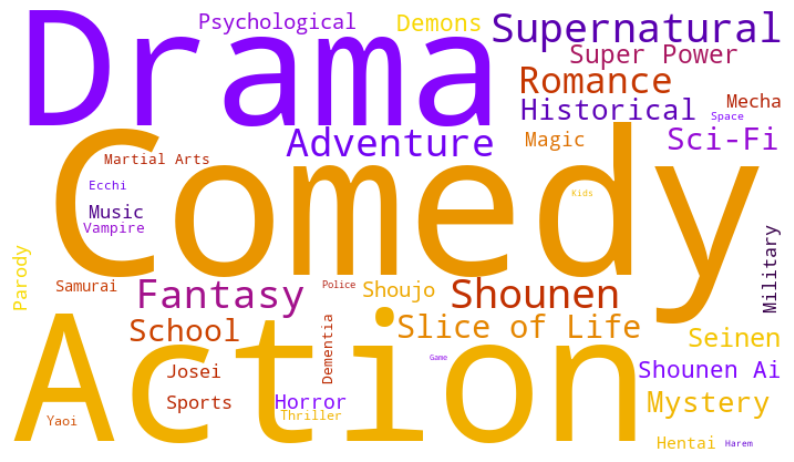

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
15926,Attack on Titan Final Season,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
...,...,...
7749,Umbrella,Fantasy
11433,Elsword: El-ui Yeoin,"Action, Fantasy"
11493,La Primavera,Music
15135,"Papa datte, Shitai",Shounen Ai


In [227]:
get_user_preferences(4903, rating_df, df, plot=True)

In [228]:
def get_user_recommendations(similiar_users, user_pref, df, synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similiar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list) 

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n": n_user_pref,
                        "anime_name": anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    }) 
    return pd.DataFrame(recommended_animes).head(n)

In [ ]:
similiar_users = find_similar_users(int(11558), user_weights= user_weights, user2user_encoded=user2user_encoded, user2user_decoded=user2user_decoded)

In [230]:
user_pref = get_user_preferences(4903, rating_df, df, plot=False)

In [231]:
get_user_recommendations(similiar_users, user_pref, df, synopsis_df=synopsis_df, rating_df=rating_df )

,n,anime_name,Genres,Synopsis
0,7,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world."
1,7,Sword Art Online,"Action, Game, Adventure, Romance, Fantasy","In the year 2022, virtual reality has progressed by leaps and bounds, and a massive online role-playing game called Sword Art Online (SAO) is launched. With the aid of ""NerveGear"" technology, players can control their avatars within the game using nothing but their own thoughts. Kazuto Kirigaya, nicknamed ""Kirito,"" is among the lucky few enthusiasts who get their hands on the first shipment of the game. He logs in to find himself, with ten-thousand others, in the scenic and elaborate world of Aincrad, one full of fantastic medieval weapons and gruesome monsters. However, in a cruel turn of events, the players soon realize they cannot log out; the game's creator has trapped them in his new world until they complete all one hundred levels of the game. In order to escape Aincrad, Kirito will now have to interact and cooperate with his fellow players. Some are allies, while others are foes, like Asuna Yuuki, who commands the leading group attempting to escape from the ruthless game. To make matters worse, Sword Art Online is not all fun and games: if they die in Aincrad, they die in real life. Kirito must adapt to his new reality, fight for his survival, and hopefully break free from his virtual hell."
2,7,Kaguya-sama:Love is War,"Comedy, Psychological, Romance, School, Seinen","he renowned Shuchiin Academy, Miyuki Shirogane and Kaguya Shinomiya are the student body's top representatives. Ranked the top student in the nation and respected by peers and mentors alike, Miyuki serves as the student council president. Alongside him, the vice president Kaguya—eldest daughter of the wealthy Shinomiya family—excels in every field imaginable. They are the envy of the entire student body, regarded as the perfect couple. However, despite both having already developed feelings for the other, neither are willing to admit them. The first to confess loses, will be looked down upon, and will be considered the lesser. With their honor and pride at stake, Miyuki and Kaguya are both equally determined to be the one to emerge victorious on the battlefield of love!"
3,7,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable t

### **Hybrid Recommender System**

In [232]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

In [233]:
hybrid_recommendation(15597)

['Bakuman.', 'Fairy Tail', 'Soul Eater', 'Gintama', 'Another', 'Whisper of the Heart', 'Fairy Tail Series 2', 'One Piece Film Z', 'Castle in the Sky', 'Maid Sama!']
Anime closest to Bakuman.
Anime closest to Fairy Tail
Anime closest to Soul Eater
Anime closest to Gintama
Anime closest to Another
Anime closest to Whisper of the Heart
Anime closest to Fairy Tail Series 2
Anime closest to One Piece Film Z
Anime closest to Castle in the Sky
Anime closest to Maid Sama!


['Maihime',
 'Bakuman.',
 'Fairy Tail',
 'Soul Eater',
 'Gintama',
 'Another',
 'Whisper of the Heart',
 'Fairy Tail Series 2',
 'One Piece Film Z',
 'Castle in the Sky']